# GRAPE calculation of control fields for cnot implementation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from qutip import *
from qutip_qtrl import *
from qutip_qoc import time_interval # new

In [3]:
T = 2 * np.pi 
times = np.linspace(0, T, 500)
t_interval = time_interval.TimeInterval(evo_time=T, tslots=times) # new

In [4]:
U = qutip.gates.cnot() # fix
R = 500
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]

H_labels = [r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
            r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

In [5]:
H0 = 0 * np.pi * (tensor(sigmax(), identity(2)) + tensor(identity(2), sigmax()))

c_ops = []

# This is the analytical result in the absense of single-qubit tunnelling
#g = pi/(4 * T)
#H = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))

# GRAPE

In [6]:
from qutip_qtrl.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary

In [7]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [8]:
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

u_limits = None #[0, 1 * 2 * pi]
alpha = None

In [9]:
result_grape = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar(R))

10.0%. Run time:   8.43s. Est. time left: 00:00:01:15
20.0%. Run time:  17.07s. Est. time left: 00:00:01:08
30.0%. Run time:  25.04s. Est. time left: 00:00:00:58
40.0%. Run time:  32.81s. Est. time left: 00:00:00:49
50.0%. Run time:  40.61s. Est. time left: 00:00:00:40
60.0%. Run time:  48.52s. Est. time left: 00:00:00:32
70.0%. Run time:  56.46s. Est. time left: 00:00:00:24
80.0%. Run time:  64.59s. Est. time left: 00:00:00:16
90.0%. Run time:  72.65s. Est. time left: 00:00:00:08
Total run time:  81.06s


In [10]:
result_adaptive = grape_unitary_adaptive(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                                    eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                                    overlap_terminate=0.9999,
                                    progress_bar=TextProgressBar(R))

10.0%. Run time:  35.04s. Est. time left: 00:00:05:15
20.0%. Run time:  72.31s. Est. time left: 00:00:04:49
Total run time:  82.56s


In [11]:
U_f, H_list_func, u = result_adaptive.U_f, result_adaptive.H_t, result_adaptive.u

## Fidelity/overlap

In [12]:
_overlap(U, result_grape.U_f).real, abs(_overlap(U, result_grape.U_f)) ** 2

(0.7071067811865483, 1.0000000000000022)

# GOAT

In [13]:
from qutip_qoc.pulse import SinPulse
from qutip_qoc.optimize import optimize_pulses
from qutip_qoc.objective import Objective

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\dots \\ \\
    c_k(\vec{\alpha}, t) = \sum^{N_\mathrm{sup}} \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

In [14]:
n_sup, n_var = 3, 3 # three summands of three variables, for each control

sin = SinPulse(n_sup)

# every contol must have different parameter signature for QobjEvo
controls = [
    lambda t,p: sin.gen_pulse(t,p),
    lambda t,q: sin.gen_pulse(t,q),
    lambda t,r: sin.gen_pulse(t,r),
    lambda t,s: sin.gen_pulse(t,s),
    lambda t,u: sin.gen_pulse(t,u),
    lambda t,v: sin.gen_pulse(t,v),
    lambda t,w: sin.gen_pulse(t,w),
]

gradients = [
    lambda t,p,idx: sin.gen_grad(t,p,idx),
    lambda t,q,idx: sin.gen_grad(t,q,idx),
    lambda t,r,idx: sin.gen_grad(t,r,idx),
    lambda t,s,idx: sin.gen_grad(t,s,idx),
    lambda t,u,idx: sin.gen_grad(t,u,idx),
    lambda t,v,idx: sin.gen_grad(t,v,idx),
    lambda t,w,idx: sin.gen_grad(t,w,idx),
]

In [15]:
H = [H0] + [[h_ops, ctrl, {"grad": grd}] for h_ops, ctrl, grd in zip(H_ops, controls, gradients)]

In [16]:
p_opts = {}

for ctrl in controls:
    p_opts[ctrl] = {
        "guess": np.ones(n_sup * n_var),
        "bounds": [(-10, 10) for _ in range(n_sup * n_var)]
    }

In [17]:
initial = qutip.tensor(qutip.qeye(2), qutip.qeye(2))
objective = Objective(initial, H, U)

In [18]:
result_goat = optimize_pulses(
    objectives=[objective],
    pulse_options=p_opts,
    time_interval=t_interval,
    time_options={},
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "seed": 0,
    },
    minimizer_kwargs={},
    integrator_kwargs={}
)

{}


In [19]:
result_goat.final_states[0].full()

100.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s


array([[-0.74368041+0.65860232j,  0.01141502-0.075802j  ,
        -0.03750092-0.00409874j, -0.01463178-0.07527802j],
       [-0.07461752+0.00755749j, -0.72091152+0.68713345j,
         0.02055999+0.0058095j ,  0.0420973 -0.01668053j],
       [-0.07868092-0.00971486j, -0.00668827+0.04180844j,
        -0.04610077+0.0444207j , -0.60624664+0.78758279j],
       [ 0.00420233-0.03538569j,  0.00674522+0.02043437j,
        -0.73589273+0.67266655j,  0.04291999-0.04901968j]])

## Test numerical integration

In [20]:
H_t_evo = qutip.QobjEvo(result_grape.H_t, tlist=times)
U_f_numerical = propagator(H_t_evo, times, [], args={})

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.02s. Est. time left: 00:00:00:00
40.1%. Run time:   0.03s. Est. time left: 00:00:00:00
50.1%. Run time:   0.03s. Est. time left: 00:00:00:00
60.1%. Run time:   0.04s. Est. time left: 00:00:00:00
70.1%. Run time:   0.05s. Est. time left: 00:00:00:00
80.2%. Run time:   0.06s. Est. time left: 00:00:00:00
90.2%. Run time:   0.06s. Est. time left: 00:00:00:00
100.0%. Run time:   0.07s. Est. time left: 00:00:00:00
Total run time:   0.07s


In [21]:
_overlap(result_grape.U_f, U_f_numerical[-1]).real, abs(_overlap(result_grape.U_f, U_f_numerical[-1]))**2

(0.9998374626026852, 0.999674951623788)

# Process tomography

## Ideal cnot gate

In [22]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

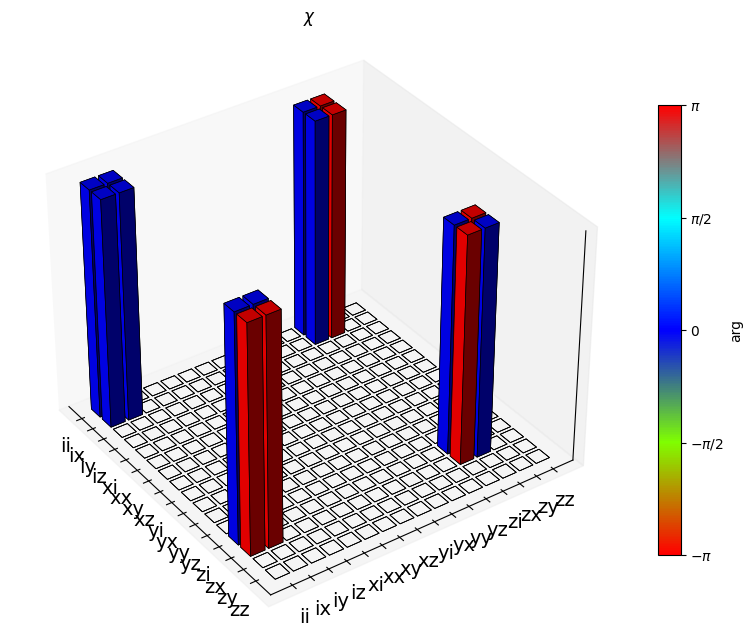

In [23]:
fig = plt.figure(figsize=(12,6))

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## cnot gate calculated using GRAPE

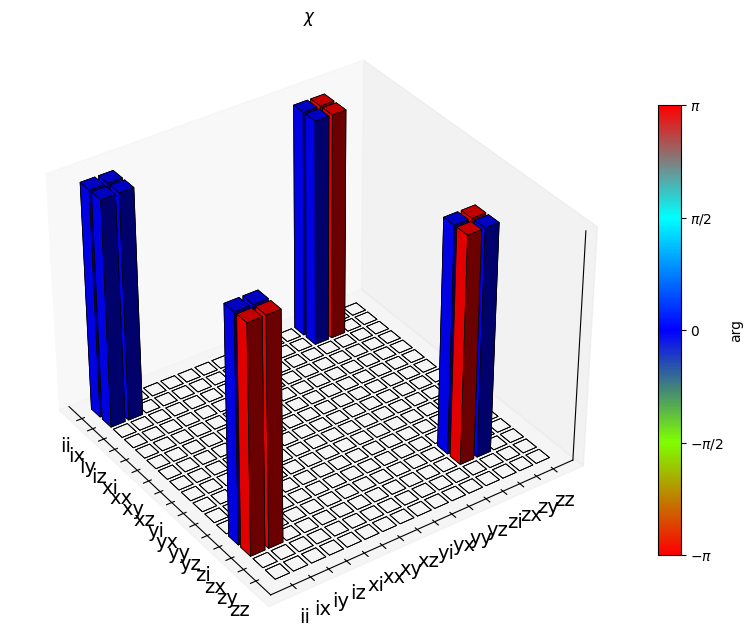

In [24]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result_grape.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## cnot gate calculated using GOAT

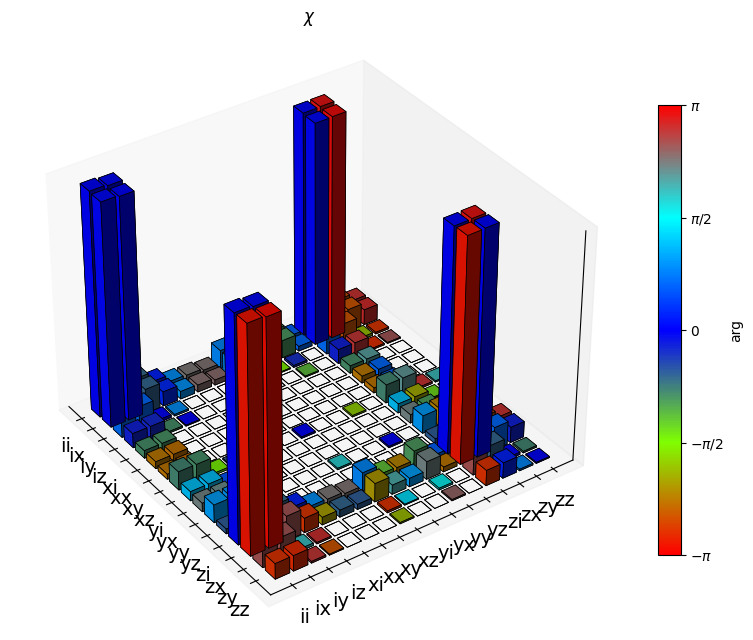

In [25]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result_goat.final_states[-1])

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [26]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,5.0.0.dev0+2dc5f3f
Numpy,1.25.2
SciPy,1.11.1
matplotlib,3.7.2
Number of CPUs,8
BLAS Info,INTEL MKL
IPython,8.15.0
Python,"3.11.4 | packaged by Anaconda, Inc. | (main, Jul 5 2023, 13:47:18) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]
Cython,3.0.0
